# <center> TEMAS SELECTOS DE ESTADÍSTICA <center>

Militza Andrea Amaya Moguel

### <font color=black>Ejercicio 1</font>
Realice la gráfica de la frontera óptima para el proceso verdadero, dentro de muestra y fuera de muestra:
### <font color=pink>Solución</font>

Se asume que:
* Hay un retorno esperado del 100%. $\mu =(1,..,1)'$
* $\Sigma = I$
* Matriz de covarianza muestral S es una matriz aleatoria del ensamble de Whishart con $\sigma=0.2$

Con $p=100$ y $n=200$ se genera la matriz de datos X

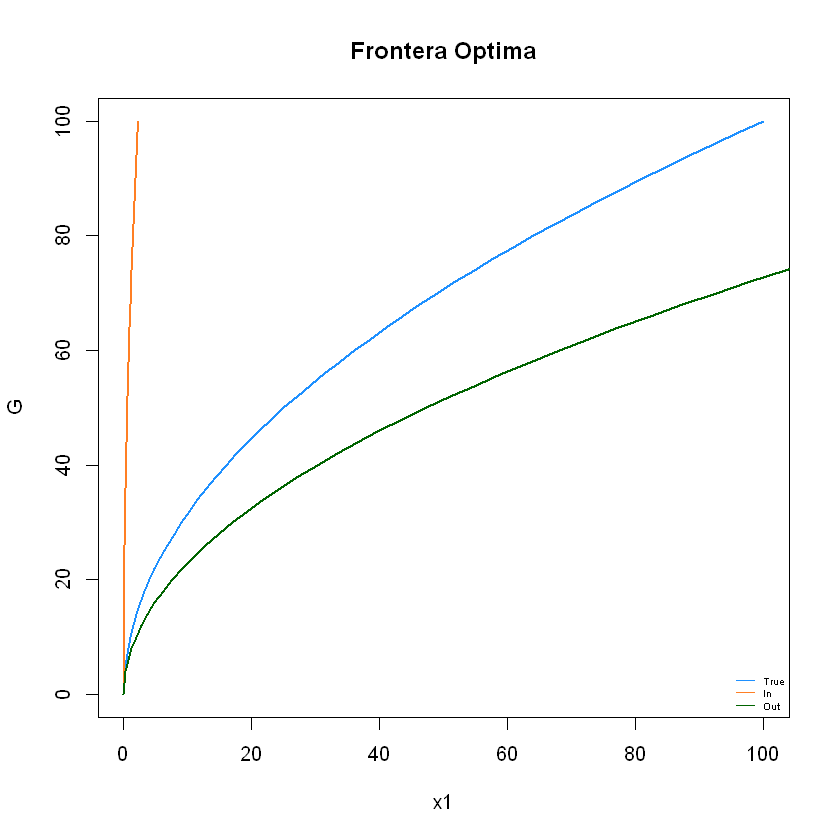

In [42]:
#Se asume que:
p <- 100                                                             # variables
n<- 200                                                              # observaciones
mu <- matrix(1, p, 1)
Sigma <- diag(1, p, p)

                                                        
Z <- replicate(n = p, sample(rnorm(n = n, mean = 0, sd = 1)))      # Generación de datos
D <- diag(.2, n, n)
X <- D%*%Z

W <- (1/n)*t(X)%*%(X)                                                # Matriz Wishar
W.inv <- solve(W)

G <- seq(from=0, to = 100, by = 2)


# Risck
R.true <- function(G){
  x1<- G^2/(t(mu)%*%Sigma%*%mu)
  x1
}

R.in <- function(G){
  x2<- G^2/(t(mu)%*%W.inv%*%mu)
  x2
}

R.out <- function(G){
  x3 <- G^2%*%((t(mu)%*%W.inv%*%Sigma%*%W.inv%*%mu)/(t(mu)%*%W.inv%*%mu)^2)
  x3
}

x1 <- sapply(G, R.true)
x2 <- sapply(G, R.in)
x3 <- sapply(G, R.out)


plot(x1, G, col="dodgerblue", type = 'l', main = "Frontera Optima", lwd=2)
lines(x2, G, col="chocolate1", lwd=2)
lines(x3, G, col="darkgreen", lwd=2)
legend("bottomright", legend = c("True", "In", "Out"), col=c("dodgerblue","chocolate1", "darkgreen"), lty=c(1,1), cex = 0.48, bty = 'n')


El comportamiento grafico varia al hacer muy grande o pequeño a *n* ó *p*, es decir que la medida de estos influye en que tan cercanas o lejanas son entre sí las gráficas, lo mismo ocurre al variar $\sigma$ y $\mu$. 

### <font color=black>Ejercicio 2</font>
Obtener una muestra de variables financieras en el contexto de alta dimensionalidad y mediante el proceso propuesto en *Random matrix theory and financial correlation* mejorar la frontera óptima dentro y fuera de la muestra.
### <font color=pink>Solución</font>

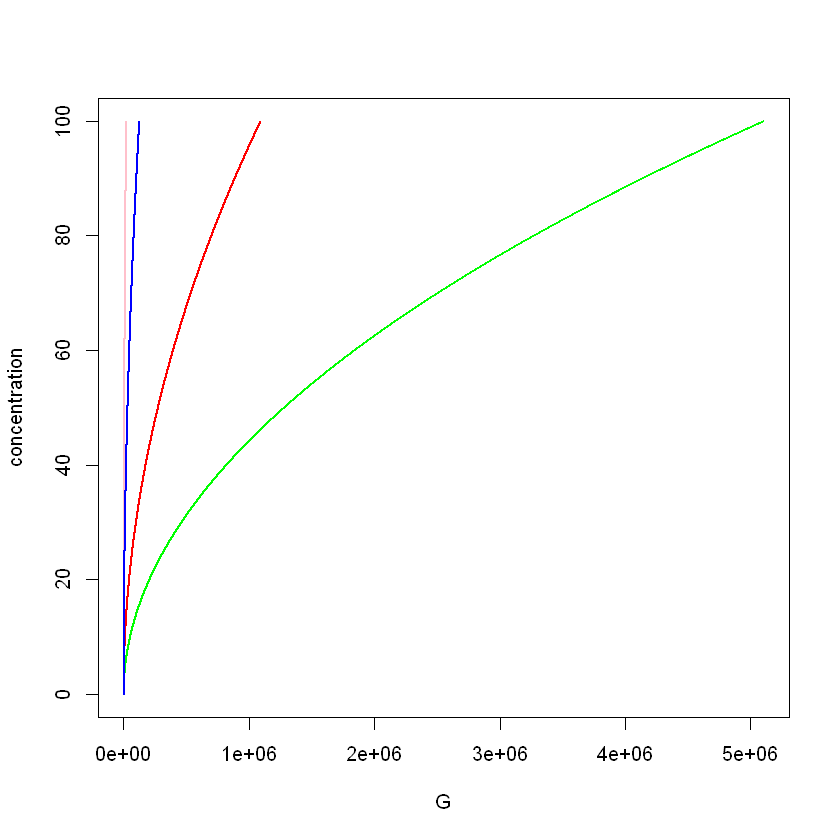

In [43]:
db <- read.csv("base_tarea5_completa.csv")          #Cargan datos
db3 <- db[301:600,]
rownames(db3) <- db3[,1] 
db3 <- db3[,-1]

n1 = nrow(db3)/2                                     #Se dividen los datos en 2 grupos
p = ncol(db3)
X1 = as.matrix(db3[1:n1,])
X2 = as.matrix( db3[(n1+1):nrow(db3),])

S1 = t(X1) %*% X1/n1                                #matrices de covarianza
S2 = t(X2) %*% X2/n1


mu1 = as.vector( colMeans(X1))                      #vector de medias
G1 =seq(from=0, to=100, length.out=10000 )

eig1 = eigen(S1)                                    #Factorizar S1
l1 <- eig1$values
O1 <- eig1$vectors

k=6                                                #los primeros eigenvalores si los da ordenados, 
                                                   #tomaremos los primeros 4, los demás los haremos constantes 

saux = 1 - sum(l1[1:k])
saux = saux/(p-k)
l1[(k+1):length(l1)]=saux 

lambda1 = diag(l1)                                 #Matriz diagonal para hacerla limpia

C1 = O1 %*% lambda1 %*% t(O1)                      #Matriz Limpia de S1 

# Pasos iguales para S2
eig2 = eigen(S2)
l2 <- eig2$values
O2 <- eig2$vectors
saux2 = 1 - sum(l2[1:k])
saux2 = saux2/(p-k)
l2[(k+1):length(l2)]=saux2 
lambda2 = diag(l2)
C2 = O2 %*% lambda2 %*% t(O2)                       #Matriz limpia para S2

# RETORNOS
# R in dirty
aux1 = as.numeric(t(mu1)%*% solve(S1)%*% mu1)
Rin_dirty <- (G1^2)/ aux1

# R in clean
aux2 = as.numeric(t(mu1)%*% solve(C1)%*% mu1)
Rin_clean <- (G1^2)/ aux2

# R out dirty
aux3 = as.numeric( (t(mu1) %*% solve(S1) %*% mu1)^2 )
aux4 = as.numeric ( t(mu1)%*% solve(S1) %*% S2 %*%solve(S1) %*% mu1 )
Rout_dirty = (G1**2) * aux4 /aux3

# R out clean
aux3 = as.numeric( (t(mu1) %*% solve(C1) %*% mu1)^2 )
aux4 = as.numeric ( t(mu1)%*% solve(C1) %*% C2 %*%solve(C1) %*% mu1 )
Rout_clean = (G1**2) * aux4 /aux3


plot(Rout_dirty,G1, type="l", col="green", lwd=2, xlab="G", ylab="concentration")
lines(Rout_clean, G1, col="red", lwd=2)
lines(Rin_dirty , G1, col="pink", lwd=2)
lines(Rin_clean , G1, col="blue", lwd=2)

Como se observó en el ejercicio anterior *n* y *p* influeyen en el comportamiento gráfico, del mismo modo mientras menos variabilidad exista de la información mejores serán los resultados.
Los resultados son muy sensibles a cambios en el conjunto de datos.

### <font color=black>Ejercicio 3</font>
Solución numérica de las ecuaciones de Painlevé para encontrar la distribución de *Tracy-Widom*
### <font color=pink>Solución</font>

A continuación se presenta el algoritmo para encontrar la distribución del valor propio más grande con $\beta=1$ y $\beta=2$

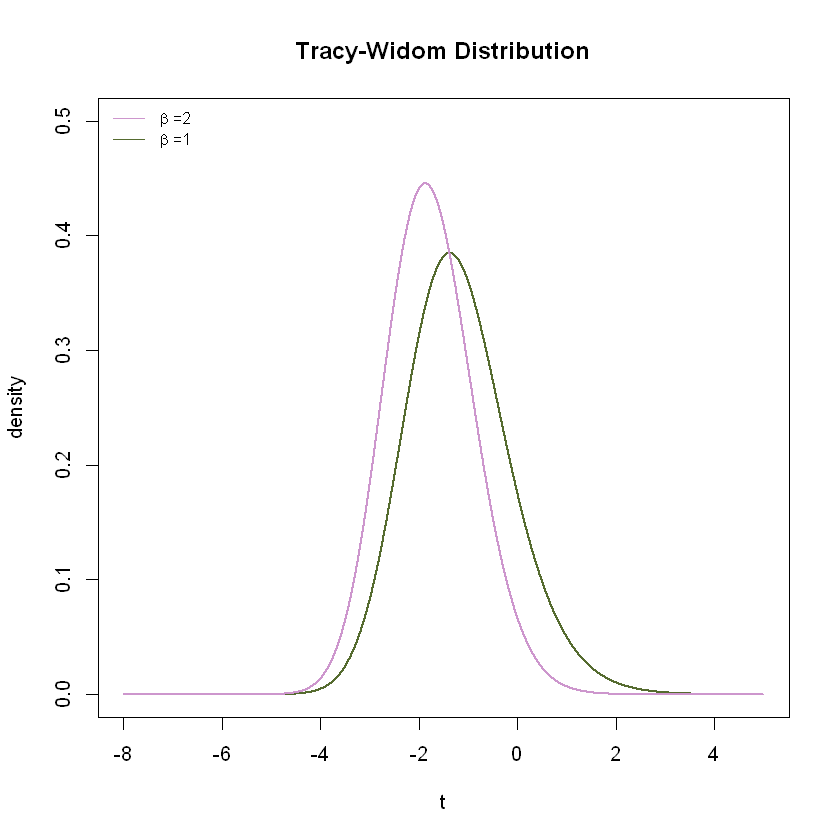

In [44]:
# Ejercicio 3
library(deSolve)
#library(gsl)
library(numDeriv)
#library(pracma)
library(deTestSet)

## F2
deq <- function(t, y, parms) {            # Ecuacion diferencial a resolver
  list(c(y[2],
         t * y[1] + 2 * y[1] ^ 3,
         y[4],
         y[1] ^ 2))
}

t0 <- 5; tn <- -8
tspan <- seq(t0, tn, length.out = 10000)    #Intervalo

y0 <- c(airy_Ai(t0),                        #y0 inicial
        airy_Ai_deriv(t0),
        0,
        airy_Ai(t0) ^ 2)

F.ode <- ode(y=y0, times=tspan, func=deq, parms=NULL, method="rk4") # Solución

F2 <- exp(-F.ode[, "3"])                    # Distribución
f2 <- gradient(F2, tspan)                   # Densidad


#F1

deqF1 <- function(t, y, parms) {          #Ecuacion diferencial a resolver
  list(c(y[2],
         t * y[1] + 2 * y[1] ^ 3,
         y[4],
         y[1]))
}

t0 <- 5; tn <- -8

tspan <- seq(t0, tn, length.out = 10000)    # Intervalo

y0 <- c(airy_Ai(t0),                        #Valor inicial
        airy_Ai_deriv(t0),
        0,
        airy_Ai(t0) ^ 2)

F.ode <- ode(y=y0, times=tspan, func=deqF1, parms=NULL, method="rk4") #Solucion

F1 <- sqrt(F2*exp(-F.ode[, "3"]))         # Distribución

f1 <- gradient(F1, tspan)                 # Densidad



#Graficos
plot(tspan, f1, ylim = c(0, 0.5), col="darkolivegreen", type = 'l', xlab = "t", ylab = "density", main = "Tracy-Widom Distribution", lwd=2)
lines(tspan, f2, col="plum3", lwd=2)
legend("topleft", legend = c(as.expression(bquote(beta~"=2")),as.expression(bquote(beta~"=1"))), col=c("plum3","darkolivegreen"), lty=c(1,1), cex = 0.8, bty = 'n')



Como se comentó en clase su distribución es semejante a la Gaussiana.

### <font color=black>Ejercicio 4</font>
Una muestra de $n=10$ observaciones viene de una $N_{10}(0, \Sigma)$y el eigenvalor propio más grande es $\lambda=4.3$
### <font color=pink>Solución</font>

* ¿Este valor es consisitente con la hipotesis $H_0=W_{10}(10,I) aun y cuando el valor 4.3 cae fuera del soporte [0,4] de la distribución de Marcenko-Pastur?

* Utilizando la aproximación de segundo orden calcla la probabilidad de encontrar un valor más extremo a 4.3

* Rechace o acepte $H_0$ bajo nivel de significancia 1%, 5% y 10%

* ¿Cuáles son las conclusiones?

In [45]:
install.packages("RMTstat")
library(RMTstat)

Installing package into 'C:/Users/acer/Documents/R/win-library/3.6'
(as 'lib' is unspecified)
Warning message:
"package 'RMTstat' is in use and will not be installed"

Con la expresión vista en clase se rescala el valor de $\lambda=4.3$ con lo que se obtuvo como valor:

In [46]:
p <- 10
n <- 10

a <- sqrt(n-1/2)
b <- sqrt(p-1/2)
mu  <- (a+b)^2                               # media
sig <- (a+b)*(1/a+1/b)^(1/3)                 #sd

Lambda <- 4.3

Lam.est <- (n*Lambda - mu)/sig               #centrando lambda=4.3
Lam.est

[1] 0.9368904

Si es consistente con la $H_0$ a pesar de caer "aparentemente" fuera del soporte de *Marcenko-Pastur*

La probabilidad de encontrar un valor más extremo que 4.3 es:

$P(\lambda >4.3)=P(\frac{\lambda -\mu^0_{np}}{\sigma^o_{np}}->\frac{4.3-\mu^0_{np}}{\sigma^o_{np}})=P(\lambda_{est}>0.93689)=1- P(\lambda_{est}<0.93689)$.

Calculado se obtiene que la probailidad es:

In [47]:
p.lambda <- 1- ptw(Lam.est)
p.lambda

[1] 0.05302342

El valor obtenido anteriormente se compara con $\alpha =0.01, 0.05, 0.1$.

Se puede observar que únicamente $p.lambda=0.053<0.1$.

Por lo que se rechaza $H_0$ con $\alpha=0.10$ de significancia.

No solo conocer la distribución del valor propio más grande en importante sino probar si es estadísticamente significante ayuda a la toma de desiciones.